# MOHAMMED FARAZ ALI

This notebook was run on my personal server using Tensor Flow version 1.8 because two models ssd_mobilenet_v2_coco_2018_03_29 and faster_rcnn_resnet50_coco_2018_01_28 did not run over the eecalcserver because Tensor Flow version 1.4.
I also copied the file CPW_AnimalKeyFile.txt to my own directory 

# ELEC 4727/5727 Final Exam Project - Object Detection 


# Imports

In [153]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import glob

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

# This is needed to display the images.
%matplotlib inline
print(tf.__version__)

1.8.0


## Object detection imports
Here are the imports from the object detection module.

In [154]:
import warnings
warnings.filterwarnings('ignore')

# This is needed since the notebook is stored in the object_detection folder.
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Model preparation 

## Variables : 4 per model (MODEL_NAME, PATH_TO_LABELS, NUM_CLASSES), 4th is PATH_TO_GRAPH_PB_FILE

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [155]:
MODELS_NAMES = ['ssd_mobilenet_v1_coco_2017_11_17','ssd_inception_v2_coco_2017_11_17','ssd_mobilenet_v2_coco_2018_03_29','faster_rcnn_resnet50_coco_2018_01_28']

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_GRAPH_PB_FILE={}
for MODEL_NAME in MODELS_NAMES:
    PATH_TO_GRAPH_PB_FILE[MODEL_NAME] = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90
print(PATH_TO_GRAPH_PB_FILE)

{'ssd_mobilenet_v1_coco_2017_11_17': 'ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb', 'ssd_inception_v2_coco_2017_11_17': 'ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb', 'ssd_mobilenet_v2_coco_2018_03_29': 'ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb', 'faster_rcnn_resnet50_coco_2018_01_28': 'faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb'}


## Load information

## 1- frozen Tensorflow model into detection graph

## 2- category_index  label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [156]:
def generate_tf_graph(frozen_file_path):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
       od_graph_def = tf.GraphDef()
       with tf.gfile.GFile(frozen_file_path, 'rb') as fid:
           serialized_graph = fid.read()
           od_graph_def.ParseFromString(serialized_graph)
           tf.import_graph_def(od_graph_def, name='')
           return detection_graph
        
def generate_category_index(path_to_labels, number_classes):
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return category_index

detection_graph={}
for MODEL_NAME in MODELS_NAMES:
    detection_graph[MODEL_NAME] = generate_tf_graph(PATH_TO_GRAPH_PB_FILE[MODEL_NAME])
    #print(PATH_TO_GRAPH_PB_FILE[MODEL_NAME])
category_index = generate_category_index(PATH_TO_LABELS,NUM_CLASSES)

# Detection Support Routines

In [157]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)  #default is 0.5
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

def generate_inference_visual_results(inference_graph, test_image_path_list, category_index):
    
    if len(test_image_path_list) > 101:  #call top ten
        print ('Do not visualize large list of images in Python Notebook')
        return
    
    # Size, in inches, of the output images.
    IMAGE_SIZE = (12, 8)
    for image_path in test_image_path_list[9:10]:   # Visualizing only top 10
        print (image_path)
        # generate numpy image
        image_np = load_image_into_numpy_array(Image.open(image_path))
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        output_dict = run_inference_for_single_image(image_np, inference_graph)
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            line_thickness=8)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)
        
def generate_inference_results_dictionary(inference_graph, test_image_path_list):
    output_result_dict = dict()
    for image_path in test_image_path_list:
        print ('Running inferernece on ' + image_path)
        # Generate numpy image 
        image_np = load_image_into_numpy_array(Image.open(image_path))
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        output_dict = run_inference_for_single_image(image_np, inference_graph)
        output_result_dict[image_path] = output_dict
    return output_result_dict

# Image test

In [158]:

TEST_IMAGES_DIR="FinalData"
TEST_IMAGE_PATHS=[]

for file in os.listdir(TEST_IMAGES_DIR):
    if(file!=".ipynb_checkpoints"):
        TEST_IMAGE_PATHS.append("FinalData/"+file)
TEST_IMAGE_PATHS=TEST_IMAGE_PATHS[100:]  #removing garbage files that was loaded on my personal machine when copying data from eecalc server
print(TEST_IMAGE_PATHS)
print(len(TEST_IMAGE_PATHS))


['FinalData/SPP-1-H-02_003466.JPG', 'FinalData/SPP-1-H-05_003779.JPG', 'FinalData/SPP-1-H-06_000947.JPG', 'FinalData/SPP-1-H-06_001442.JPG', 'FinalData/SPP-1-L-01_001481.JPG', 'FinalData/SPP-1-L-01_001610.JPG', 'FinalData/SPP-1-L-01_001659.JPG', 'FinalData/SPP-1-L-01_001660.JPG', 'FinalData/SPP-1-L-01_001663.JPG', 'FinalData/SPP-1-L-01_001666.JPG', 'FinalData/SPP-1-L-01_001667.JPG', 'FinalData/SPP-1-L-01_001669.JPG', 'FinalData/SPP-1-L-03_000322.JPG', 'FinalData/SPP-1-L-03_000385.JPG', 'FinalData/SPP-1-L-03_001268.JPG', 'FinalData/SPP-1-L-06_000059.JPG', 'FinalData/SPP-1-L-06_000072.JPG', 'FinalData/SPP-1-L-06_000073.JPG', 'FinalData/SPP-1-L-06_003306.JPG', 'FinalData/SPP-1-L-06_003307.JPG', 'FinalData/SPP-1-L-06_003308.JPG', 'FinalData/SPP-1-L-06_003309.JPG', 'FinalData/SPP-2-H-01_000724.JPG', 'FinalData/SPP-2-H-01_000729.JPG', 'FinalData/SPP-2-H-01_000802.JPG', 'FinalData/SPP-2-H-02_000085.JPG', 'FinalData/SPP-2-H-02_000086.JPG', 'FinalData/SPP-2-H-02_000087.JPG', 'FinalData/SPP-2-H-

# Generate visual inference view

MODEL=  ssd_mobilenet_v1_coco_2017_11_17
FinalData/SPP-1-L-01_001666.JPG
MODEL=  ssd_inception_v2_coco_2017_11_17
FinalData/SPP-1-L-01_001666.JPG
MODEL=  ssd_mobilenet_v2_coco_2018_03_29
FinalData/SPP-1-L-01_001666.JPG
MODEL=  faster_rcnn_resnet50_coco_2018_01_28
FinalData/SPP-1-L-01_001666.JPG


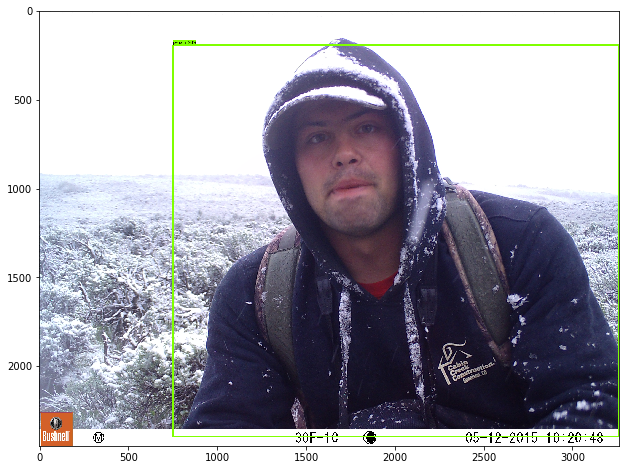

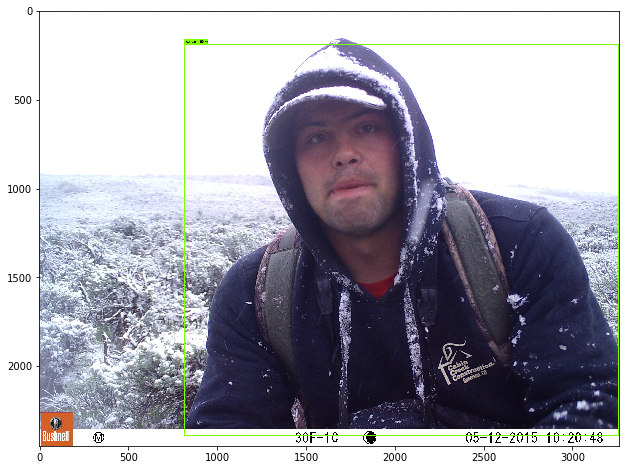

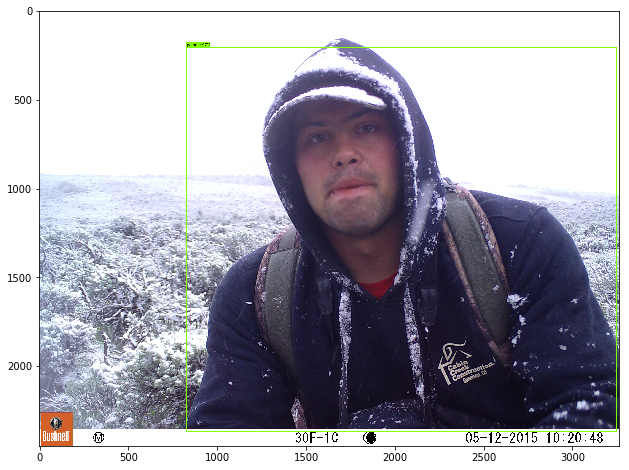

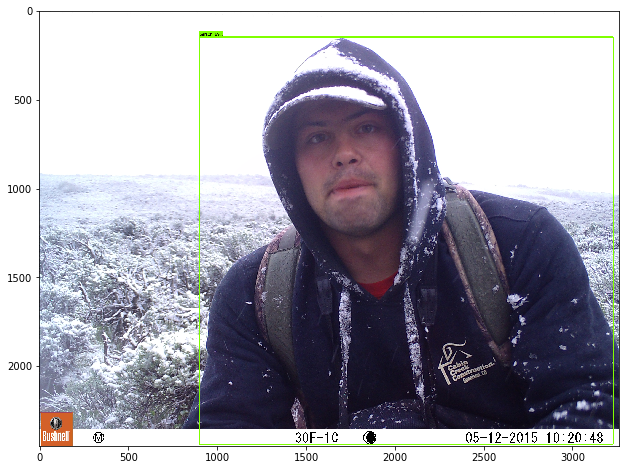

In [159]:
#showing visual inference only one images of each model 
# ssd_mobilenet_v1_coco_2017_11_17 , ssd_inception_v2_coco_2017_11_17 , ssd_mobilenet_v2_coco_2018_03_29', faster_rcnn_resnet50_coco_2018_01_28 
for MODEL_NAME in MODELS_NAMES:
    print("MODEL= ", MODEL_NAME)
    generate_inference_visual_results(detection_graph[MODEL_NAME], TEST_IMAGE_PATHS, category_index)    

In [160]:
CPW_animal_class_dict = dict()
CPW_animal_class_dict[1] = 'person'
CPW_animal_class_dict[16] = 'bird'
CPW_animal_class_dict[17] = 'cat'
CPW_animal_class_dict[18] = 'dog'
CPW_animal_class_dict[19] = 'horse'
CPW_animal_class_dict[20] = 'sheep'
CPW_animal_class_dict[21] = 'cow'
CPW_animal_class_dict[23] = 'bear'

CPW_animal_list = ['person','bird','cat','dog','horse','sheep','cow','bear']


# Generate result arrays of inferences : classes and scores by selecting a threshold. The output is class detected and number of animal in the images for each model

In [161]:
import cv2
from collections import defaultdict

output_result_dict={}
t={}
my_result=defaultdict(dict)
my_prediction=defaultdict(dict)

for MODEL_NAME in MODELS_NAMES:
    print("\n")
    print(MODEL_NAME)
    print("\n")
    e1 = cv2.getTickCount() 
    output_result_dict[MODEL_NAME] = generate_inference_results_dictionary(detection_graph[MODEL_NAME], TEST_IMAGE_PATHS)
    e2 = cv2.getTickCount()
    t[MODEL_NAME] = (e2 - e1)/cv2.getTickFrequency()
    threshold_score=0.6   #0.8 gives good strict results
    for image_path in output_result_dict[MODEL_NAME]:
        print("\n")
        x=image_path.split("/")[-1] #getting image name
        print(x)
        detection_classes = output_result_dict[MODEL_NAME][image_path]['detection_classes']
        detection_scores = output_result_dict[MODEL_NAME][image_path]['detection_scores']
        argval=np.argwhere(detection_scores>threshold_score)
    
        classesDetected=[]
        index=[]
        replace_classesDetected=[]
    
        for i in range(0,len(argval)):
            if detection_classes[argval[i][0]] in list(CPW_animal_class_dict.keys()):
                classesDetected.append(detection_classes[argval[i][0]])
                index.append(argval[i][0])
    
        print("The Classes Detected are: ", classesDetected)
        print("The Number of Animal Detetcted : ", len(classesDetected))
        #replace_classesFound = ["bear" if x == 23 else None for x in classesFound]
        for i in classesDetected:
            replace_classesDetected.append(CPW_animal_class_dict[i])
    
        if not replace_classesDetected:  #if list is empty
            replace_classesDetected.append("NONE")
        print("The Replaced Classes Detected: ", replace_classesDetected)
        #my_result[MODEL_NAME][x] = {i:list(classesDetected).count(i) for i in list(classesDetected)}
        my_prediction[MODEL_NAME][x]=replace_classesDetected
        
        
print("my_result",my_result)
print("\n\n")
print("my_prediction", my_prediction)




ssd_mobilenet_v1_coco_2017_11_17


Running inferernece on FinalData/SPP-1-H-02_003466.JPG
Running inferernece on FinalData/SPP-1-H-05_003779.JPG
Running inferernece on FinalData/SPP-1-H-06_000947.JPG
Running inferernece on FinalData/SPP-1-H-06_001442.JPG
Running inferernece on FinalData/SPP-1-L-01_001481.JPG
Running inferernece on FinalData/SPP-1-L-01_001610.JPG
Running inferernece on FinalData/SPP-1-L-01_001659.JPG
Running inferernece on FinalData/SPP-1-L-01_001660.JPG
Running inferernece on FinalData/SPP-1-L-01_001663.JPG
Running inferernece on FinalData/SPP-1-L-01_001666.JPG
Running inferernece on FinalData/SPP-1-L-01_001667.JPG
Running inferernece on FinalData/SPP-1-L-01_001669.JPG
Running inferernece on FinalData/SPP-1-L-03_000322.JPG
Running inferernece on FinalData/SPP-1-L-03_000385.JPG
Running inferernece on FinalData/SPP-1-L-03_001268.JPG
Running inferernece on FinalData/SPP-1-L-06_000059.JPG
Running inferernece on FinalData/SPP-1-L-06_000072.JPG
Running inferernece on Final

Running inferernece on FinalData/SPP-1-H-05_003779.JPG
Running inferernece on FinalData/SPP-1-H-06_000947.JPG
Running inferernece on FinalData/SPP-1-H-06_001442.JPG
Running inferernece on FinalData/SPP-1-L-01_001481.JPG
Running inferernece on FinalData/SPP-1-L-01_001610.JPG
Running inferernece on FinalData/SPP-1-L-01_001659.JPG
Running inferernece on FinalData/SPP-1-L-01_001660.JPG
Running inferernece on FinalData/SPP-1-L-01_001663.JPG
Running inferernece on FinalData/SPP-1-L-01_001666.JPG
Running inferernece on FinalData/SPP-1-L-01_001667.JPG
Running inferernece on FinalData/SPP-1-L-01_001669.JPG
Running inferernece on FinalData/SPP-1-L-03_000322.JPG
Running inferernece on FinalData/SPP-1-L-03_000385.JPG
Running inferernece on FinalData/SPP-1-L-03_001268.JPG
Running inferernece on FinalData/SPP-1-L-06_000059.JPG
Running inferernece on FinalData/SPP-1-L-06_000072.JPG
Running inferernece on FinalData/SPP-1-L-06_000073.JPG
Running inferernece on FinalData/SPP-1-L-06_003306.JPG
Running in

Running inferernece on FinalData/SPP-1-H-05_003779.JPG
Running inferernece on FinalData/SPP-1-H-06_000947.JPG
Running inferernece on FinalData/SPP-1-H-06_001442.JPG
Running inferernece on FinalData/SPP-1-L-01_001481.JPG
Running inferernece on FinalData/SPP-1-L-01_001610.JPG
Running inferernece on FinalData/SPP-1-L-01_001659.JPG
Running inferernece on FinalData/SPP-1-L-01_001660.JPG
Running inferernece on FinalData/SPP-1-L-01_001663.JPG
Running inferernece on FinalData/SPP-1-L-01_001666.JPG
Running inferernece on FinalData/SPP-1-L-01_001667.JPG
Running inferernece on FinalData/SPP-1-L-01_001669.JPG
Running inferernece on FinalData/SPP-1-L-03_000322.JPG
Running inferernece on FinalData/SPP-1-L-03_000385.JPG
Running inferernece on FinalData/SPP-1-L-03_001268.JPG
Running inferernece on FinalData/SPP-1-L-06_000059.JPG
Running inferernece on FinalData/SPP-1-L-06_000072.JPG
Running inferernece on FinalData/SPP-1-L-06_000073.JPG
Running inferernece on FinalData/SPP-1-L-06_003306.JPG
Running in

Running inferernece on FinalData/SPP-1-H-05_003779.JPG
Running inferernece on FinalData/SPP-1-H-06_000947.JPG
Running inferernece on FinalData/SPP-1-H-06_001442.JPG
Running inferernece on FinalData/SPP-1-L-01_001481.JPG
Running inferernece on FinalData/SPP-1-L-01_001610.JPG
Running inferernece on FinalData/SPP-1-L-01_001659.JPG
Running inferernece on FinalData/SPP-1-L-01_001660.JPG
Running inferernece on FinalData/SPP-1-L-01_001663.JPG
Running inferernece on FinalData/SPP-1-L-01_001666.JPG
Running inferernece on FinalData/SPP-1-L-01_001667.JPG
Running inferernece on FinalData/SPP-1-L-01_001669.JPG
Running inferernece on FinalData/SPP-1-L-03_000322.JPG
Running inferernece on FinalData/SPP-1-L-03_000385.JPG
Running inferernece on FinalData/SPP-1-L-03_001268.JPG
Running inferernece on FinalData/SPP-1-L-06_000059.JPG
Running inferernece on FinalData/SPP-1-L-06_000072.JPG
Running inferernece on FinalData/SPP-1-L-06_000073.JPG
Running inferernece on FinalData/SPP-1-L-06_003306.JPG
Running in

In [162]:
print(t)


{'ssd_mobilenet_v1_coco_2017_11_17': 667.0323701216868, 'ssd_inception_v2_coco_2017_11_17': 904.782262862597, 'ssd_mobilenet_v2_coco_2018_03_29': 797.4476389963236, 'faster_rcnn_resnet50_coco_2018_01_28': 1472.5739175128217}


# Compairing execution time for all the models

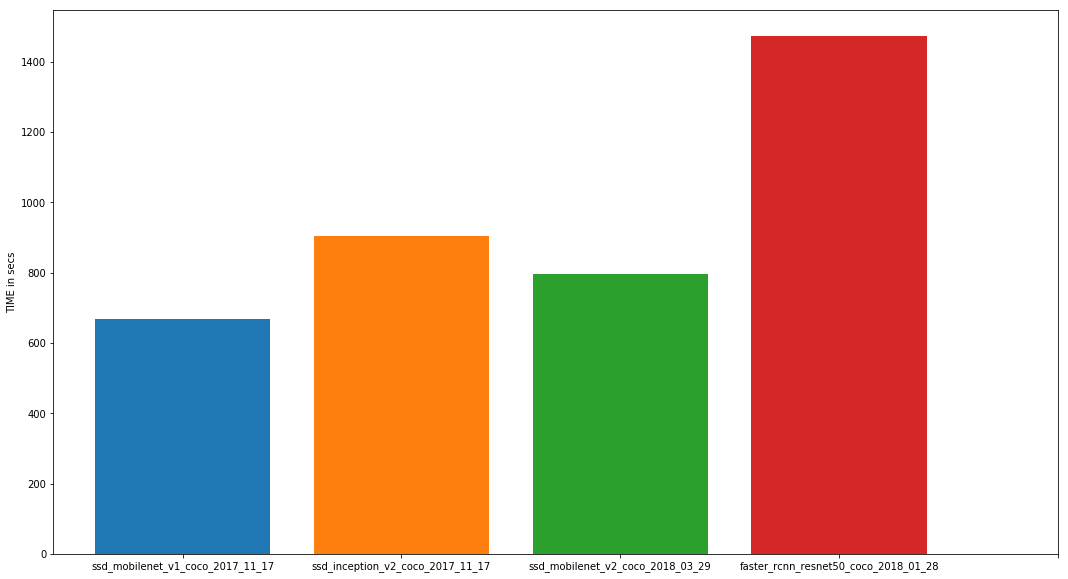

In [163]:
plt.figure(figsize=(18,10))
names = list(t.keys())
values = list(t.values())

plt.bar(0,values[0],tick_label=names[0])
plt.bar(1,values[1],tick_label=names[1])
plt.bar(2,values[2],tick_label=names[2])
plt.bar(3,values[3],tick_label=names[3])

plt.xticks(range(0,5),names)
plt.ylabel("TIME in secs")
plt.show()

# This cell creates the "answer key" for what the human detected in the images

In [164]:
#This would be my true labels
animal_key_file = 'CPW_AnimalKeyFile.txt'
animal_array = np.loadtxt(animal_key_file, skiprows=1, delimiter=',', dtype=str)

imagefile_answer_key_dict = dict()
for row in animal_array:
    imagefile_answer_key_dict[row[0]] = row[1]
    
# Example: query the image name

print (imagefile_answer_key_dict['SPP-3-L-01_003708.JPG'])  #This is truth value
print (imagefile_answer_key_dict['SPP-3-L-01_003548.JPG'])  #This is truth value

person
cow


# CodE for predictive and true results for all the images and for all the models

In [165]:
###### SHOWING CONFUSION MATRIX ONLY FOR ALL MODELs  ############
y_pred={}
y_true={}

for MODEL_NAME in MODELS_NAMES:
    p=[]
    t=[]
    for image_path in output_result_dict[MODEL_NAME]:
        x=image_path.split("/")[-1]  #getting image name
        for i in my_prediction[MODEL_NAME][x]:
            p.append(i)
            t.append(imagefile_answer_key_dict[x])
        y_pred[MODEL_NAME]=p
        y_true[MODEL_NAME]=t
        #print(i)
print("y_pred= ", y_pred)
print("\n")
print("y_true= ", y_true)
#0.8

y_pred=  {'ssd_mobilenet_v1_coco_2017_11_17': ['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'dog', 'NONE', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'bird', 'NONE', 'NONE', 'person', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'person', 'person', 'NONE', 'NONE', 'person', 'cow', 'NONE', 'NONE', 'cow', 'bear', 'NONE', 'cow', 'NONE', 'dog', 'NONE', 'person', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'cat', 'cat', 'NONE', 'NONE', 'NONE', 'NONE', 'person', 'NONE', 'person', 'NONE', 'person', 'bear', 'cow', 'cow', 'cow', 'NONE', 'NONE', 'NONE', 'cow', 'cow', 'NONE', 'horse', 'person', 'horse', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'bird', 'NONE', 'NONE', 'NONE', 'NONE', 'horse', 'person'], 'ssd_inception_v2_coco_2017_11_17': ['NONE', 'NONE', 'NONE', 'bird', 'NONE', 'N

#  Code for Confusion matrix All Models

In [166]:

def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        import itertools
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], '.1f'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')


ssd_mobilenet_v1_coco_2017_11_17
Confusion matrix, without normalization
[[15  0  0  0  3  0  0  0 15]
 [ 1  2  0  0  0  0  0  0 17]
 [ 0  0  2  0  0  0  0  0  8]
 [ 0  0  0  0  0  0  0  0 15]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 1  0  0  2  0  0  8  2 15]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]


ssd_inception_v2_coco_2017_11_17
Confusion matrix, without normalization
[[21  0  0  0  2  0  0  0 11]
 [ 1  2  0  0  0  0  0  0 17]
 [ 0  0  2  0  0  0  0  0  8]
 [ 0  1  0  0  0  0  1  1 12]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  0 14  1 12]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]


ssd_mobilenet_v2_coco_2018_03_29
Confusion matrix, without normalization
[[18  0  0  0  2  0  0  0 13]
 [ 0  0  0  0  0  0  0  0 20]
 [ 0  0  2  0  0  0  0  0  8]
 [ 0  0  0  0  0  0  0  1 14]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  0 10  2 14]
 [ 0  0  0  0  0  0  0  0

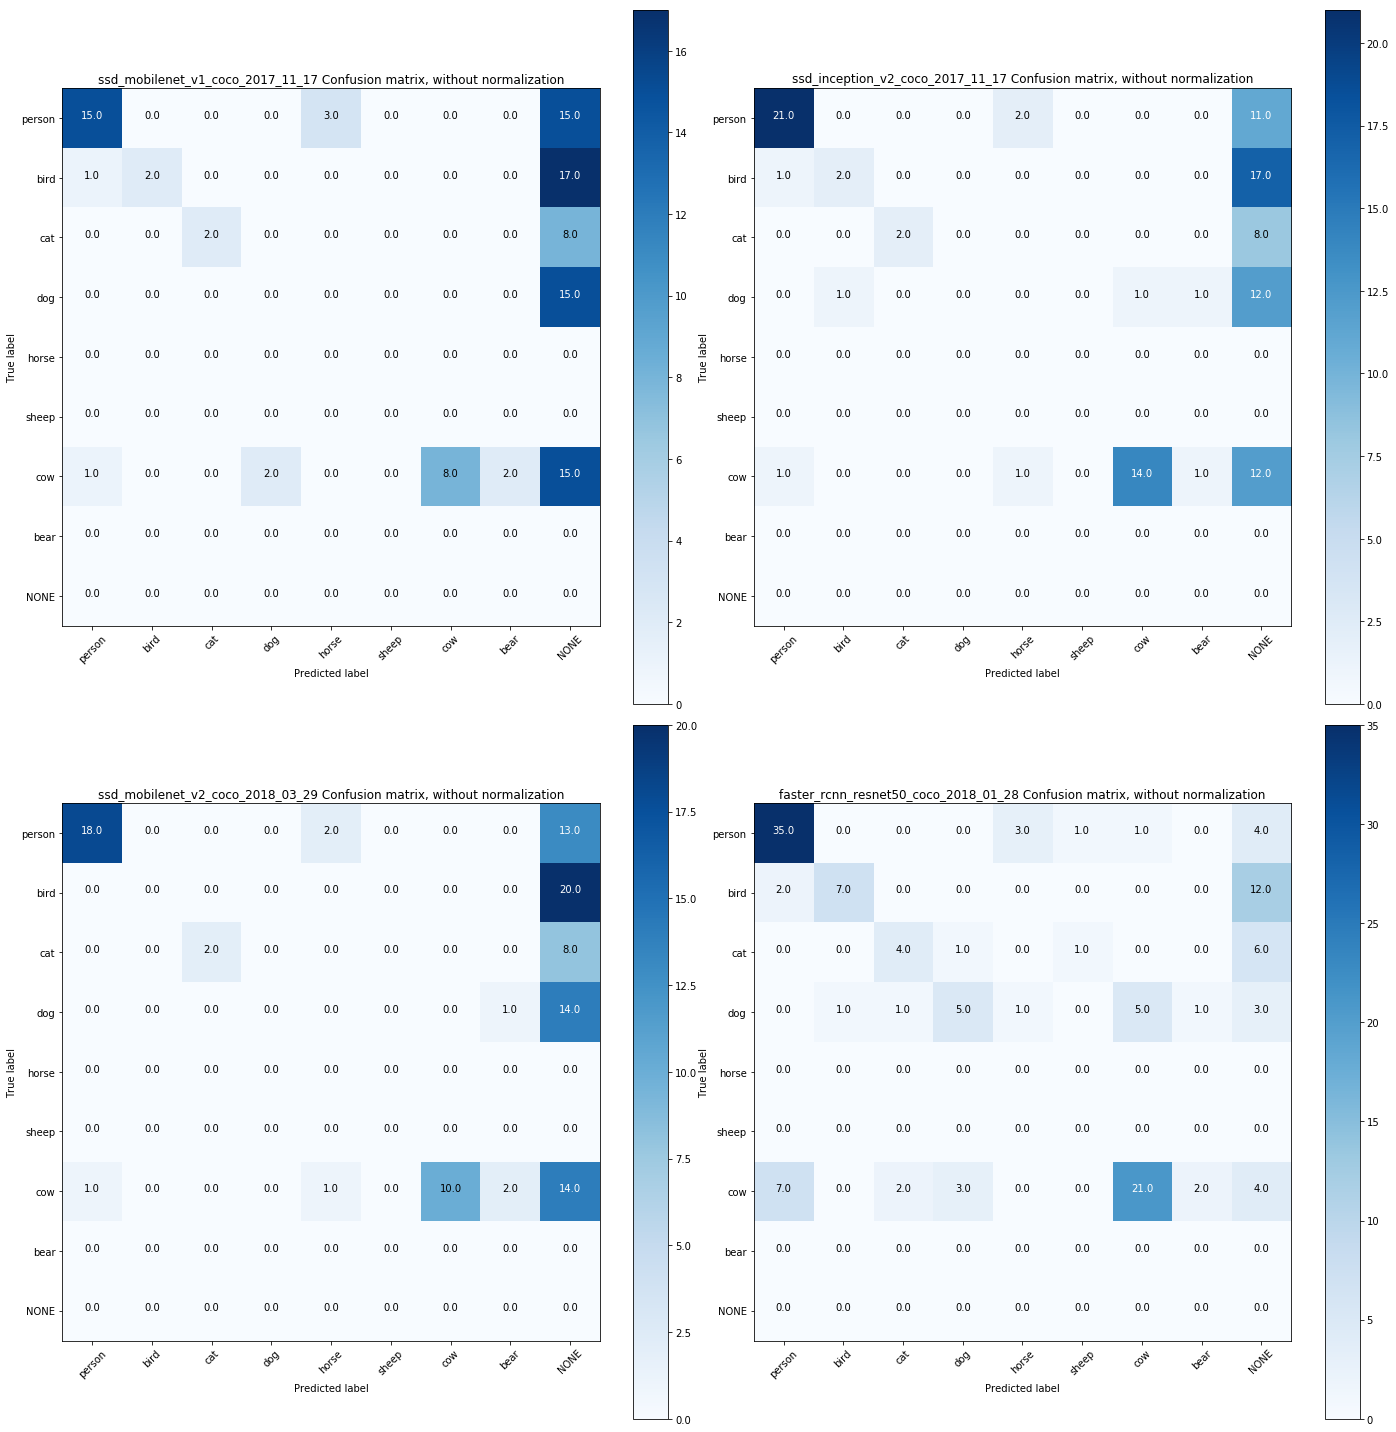

In [167]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
plt.figure(figsize=(20,20))
import matplotlib.pyplot as plt
import numpy as np
import itertools

i=1
for MODEL_NAME in MODELS_NAMES:
    print(MODEL_NAME)
    df_confusion=confusion_matrix(y_true[MODEL_NAME], y_pred[MODEL_NAME], labels=['person','bird','cat','dog','horse','sheep','cow','bear','NONE'])
    plt.subplot(2,2,i)
    
    plot_confusion_matrix(df_confusion, classes=labels,
                          title=MODEL_NAME+' Confusion matrix, without normalization')     
    i=i+1
    print("\n")
#print(df_confusion)

labels=['person','bird','cat','dog','horse','sheep','cow','bear','NONE']

    


ssd_mobilenet_v1_coco_2017_11_17
Normalized confusion matrix
[[0.45454545 0.         0.         0.         0.09090909 0.
  0.         0.         0.45454545]
 [0.05       0.1        0.         0.         0.         0.
  0.         0.         0.85      ]
 [0.         0.         0.2        0.         0.         0.
  0.         0.         0.8       ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.        ]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan]
 [0.03571429 0.         0.         0.07142857 0.         0.
  0.28571429 0.07142857 0.53571429]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan]]


ssd_inception_v2_coco_2017_11_17
Normali

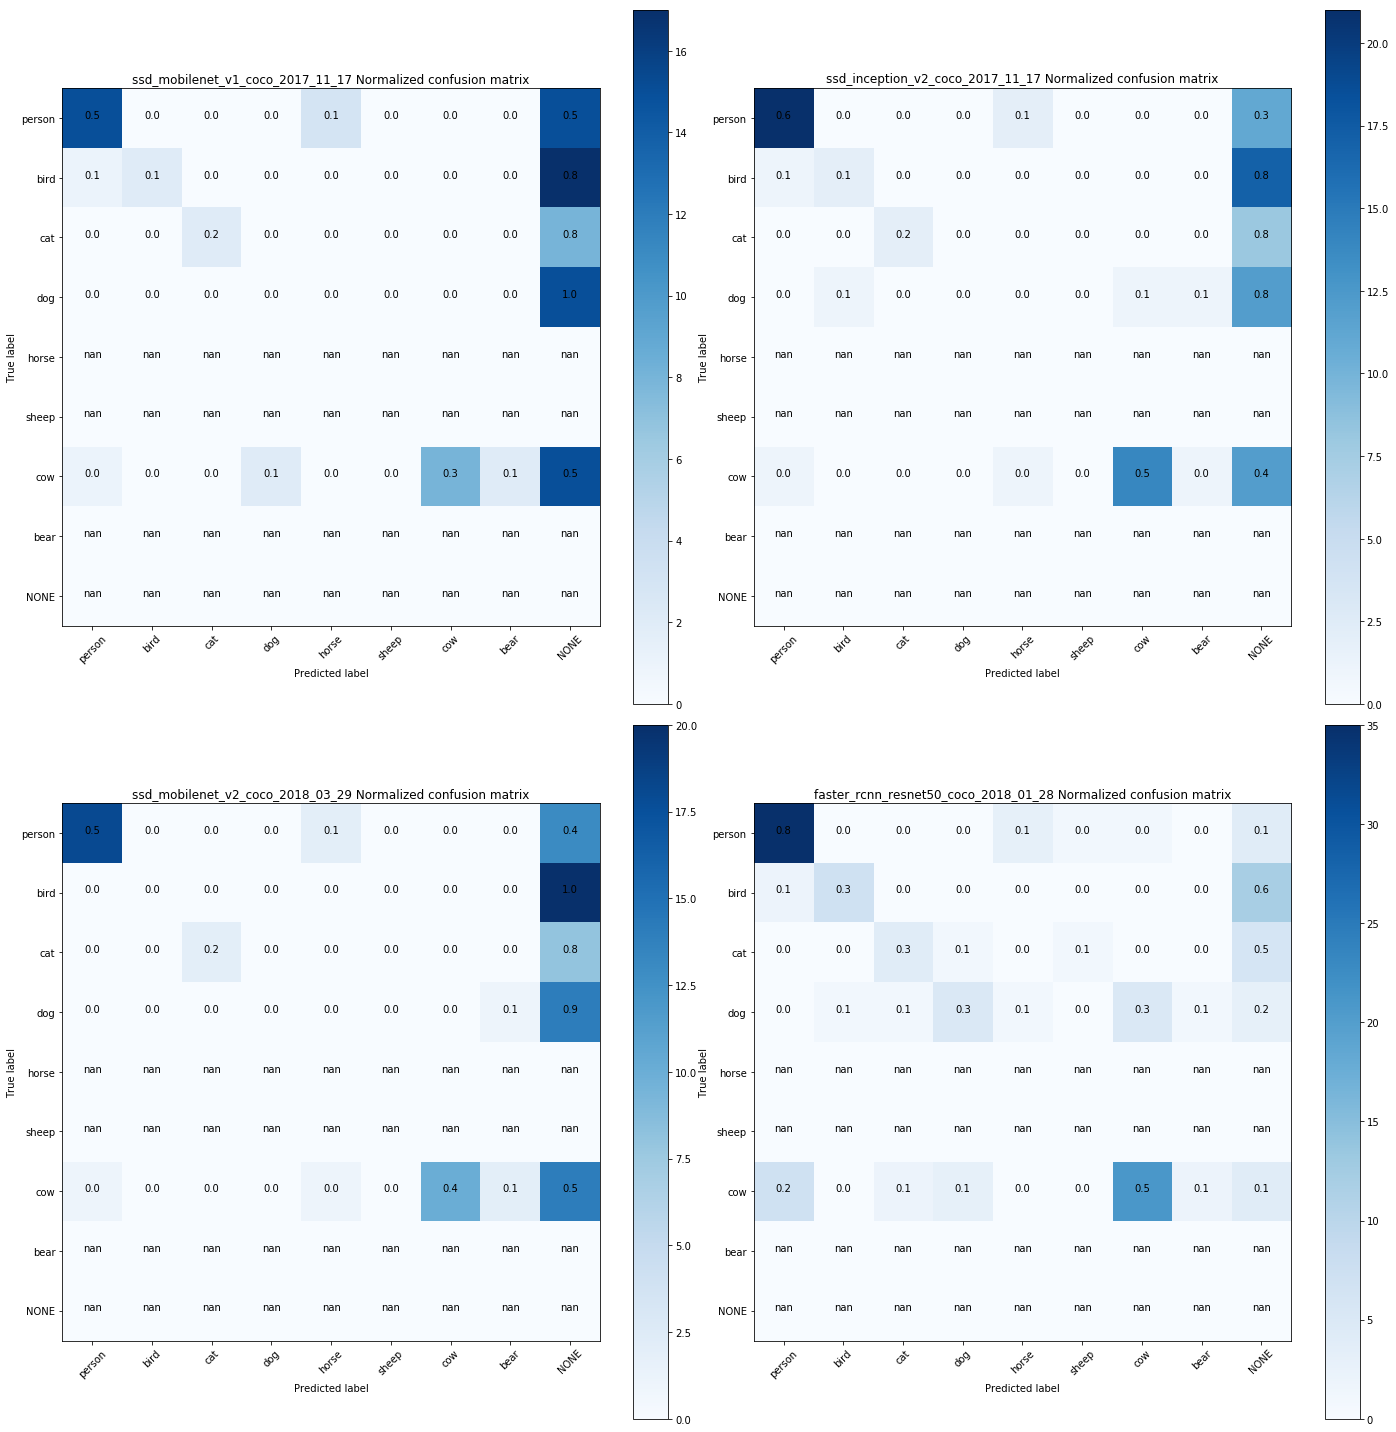

In [168]:
#Code for normalized Confusion matrix
plt.figure(figsize=(20,20))
i=1
for MODEL_NAME in MODELS_NAMES:
    print(MODEL_NAME)
    df_confusion=confusion_matrix(y_true[MODEL_NAME], y_pred[MODEL_NAME], labels=['person','bird','cat','dog','horse','sheep','cow','bear','NONE'])
    plt.subplot(2,2,i)    
    plot_confusion_matrix(df_confusion, classes=labels, normalize=True,
                      title=MODEL_NAME+' Normalized confusion matrix')     
    i=i+1
    print("\n")